This notebook is an example to show how to use an external model in SPECFEM2D

**Author:** Visrutha  
**Email:** visrutha.c@students.iiserpune.ac.in  

*Please feel free to contact me if you have any questions or suggestions.*


    

In [58]:
import numpy as np
import os
import matplotlib.pyplot as plt 
from IPython.display import Image
from scipy.interpolate import griddata

### 1)Set Up a SPECFEM Working Directory

- Copy the DATA directory named DATA_tomo
- The model used in this example is a simple checkerboard model over a homogeneous model.
- **Please change the folder directories accordingly.**

In [59]:
# Create the correct dir. and move there
! mkdir -p /home/visrutha/work/specfem2d_tomo
%cd /home/visrutha/work/specfem2d_tomo

# Symlink the executables, create empty OUTPUT_FILES
! ln -s /home/visrutha/specfem2d/bin .
! mkdir OUTPUT_FILES

# copy the DATA directory I have shared along with this notebook
! cp -r /home/visrutha/specfem2d/DATA_tomo DATA

! ls

/home/visrutha/work/specfem2d_tomo
bin  DATA  OUTPUT_FILES


### 2) External tomography model

To define an external velocity model in SPECFEM2D,
* Set MODEL as ``default`` in Par file
* Then define the velocity model in Par file for a tomo model : ``model_number -1 0 0 A 0 0 0 0 0 0 0 0 0 0``.
    *  model_number must be strictly positive
    *  the following domain number must be negative (-1) for tomographic models
    *  A, must be either zero (0.0) to be recognized as an acoustic region or a positive non-zero value (e.g., 1.0) for an elastic region.
* The tomographic model values are overimposed on this region, and defined in the file specified by the parameter ``TOMOGRAPHY_FILE``

In [60]:
! head -65 DATA/Par_file | tail -n 1

MODEL                           = default


In [36]:
! head -258 DATA/Par_file | tail -n 28

#-----------------------------------------------------------
#
# Velocity and density models
#
#-----------------------------------------------------------

# number of model materials
nbmodels                        = 1
# available material types (see user manual for more information)
#   acoustic:              model_number 1 rho Vp 0  0 0 QKappa 9999 0 0 0 0 0 0 (for QKappa use 9999 to ignore it)
#   elastic:               model_number 1 rho Vp Vs 0 0 QKappa Qmu  0 0 0 0 0 0 (for QKappa and Qmu use 9999 to ignore them)
#   anisotropic:           model_number 2 rho c11 c13 c15 c33 c35 c55 c12 c23 c25   0 QKappa Qmu
#   anisotropic in AXISYM: model_number 2 rho c11 c13 c15 c33 c35 c55 c12 c23 c25 c22 QKappa Qmu
#   poroelastic:           model_number 3 rhos rhof phi c kxx kxz kzz Ks Kf Kfr etaf mufr Qmu
#   tomo:                  model_number -1 0 0 A 0 0 0 0 0 0 0 0 0 0
#
# note: When viscoelasticity or viscoacousticity is turned on,
#       the Vp and Vs values that are read here are

#### 2a)Tomography model format

- The external tomographic model is represented by a grid of points with assigned material properties and homogeneous resolution along each spatial direction x and z.
- The ASCII file file_name that describe the tomography model should be located in the TOMOGRAPHY_PATH directory, set in the DATA/Par_file.
- The file starts with a header information

    * **ORIG_X, ORIG_Z, END_X, END_Z** :-  the coordinates of the initial and final tomographic grid points along the x and z direction respectively ($m$)
    * **SPACING_X, SPACING_Z** :- the spacing between the tomographic grid points along the x and z directions, respectively ($m$)
    * **NX, NZ** :- the number of grid points along the spatial directions x and z, respectively; NX is given by [(END_X - ORIG_X)/SPACING_X]+1; NZ is the same as NX, but for the z direction
    * **VP_MIN, VP_MAX, VS_MIN, VS_MAX, RHO_MIN, RHO_MAX** :- the minimum and maximum values of the wave speed vp and vs (in $m\, s^{-1}$) and of the density rho (in $kg\, m^{-3}$); these values could be the actual limits of the tomographic parameters in the grid or the minimum and maximum values to which SPECFEM force the cut of velocity and density in the model.
    * After the first four lines, the tomography file file_name lists the data record where all tomographic grid points are listed with the corresponding values of vp, vs and rho (and optionally $Q_{p}$ and $Q_{s}$), **scanning the grid along the x coordinate (from ORIG_X to END_X with step of SPACING_X) for each given z (from ORIG_Z to END_Z, with step of SPACING_Z).** You have to be careful about the order.

In [37]:
! head -15 DATA/tomography_model.txt 

270000.00 0.00 420000.00 100000.00
1000.00 500.00
151 201
5752.85 6357.15 3325.35 3674.65 2394.25 2645.75
270000.00 0.00 6055.00 3500.00 2520.00
271000.00 0.00 6055.00 3500.00 2520.00
272000.00 0.00 6055.00 3500.00 2520.00
273000.00 0.00 6055.00 3500.00 2520.00
274000.00 0.00 6055.00 3500.00 2520.00
275000.00 0.00 6055.00 3500.00 2520.00
276000.00 0.00 6055.00 3500.00 2520.00
277000.00 0.00 6055.00 3500.00 2520.00
278000.00 0.00 6055.00 3500.00 2520.00
279000.00 0.00 6055.00 3500.00 2520.00
280000.00 0.00 6055.00 3500.00 2520.00


#### 2b) Running the solver and the mesher

In [61]:
! /usr/bin/mpirun -n 8 bin/xmeshfem2D > OUTPUT_FILES/output_meshfem2d.txt

In [62]:
! /usr/bin/mpirun -n 8 bin/xspecfem2D > OUTPUT_FILES/output_solver.txt


In [63]:
! ls OUTPUT_FILES

Database00000.bin	    mesh_materials.vtk
Database00001.bin	    mesh_partition_number.vtk
Database00002.bin	    output_list_stations.txt
Database00003.bin	    output_meshfem2d.txt
Database00004.bin	    output_solver.txt
Database00005.bin	    plotall_gll_mesh.gnu
Database00006.bin	    plotall_macro_mesh.gnu
Database00007.bin	    plot_gridfile.gnu
forward_image000000005.jpg  plot_points_per_wavelength_histogram.gnu
forward_image000001000.jpg  plot_source_time_function.txt
forward_image000002000.jpg  points_per_wavelength_histogram_S_in_solid.txt
forward_image000003000.jpg  proc000000_data.bin
forward_image000004000.jpg  proc000000_receivers_info.bin
forward_image000005000.jpg  proc000000_sources_info.bin
forward_image000006000.jpg  proc000001_data.bin
forward_image000007000.jpg  proc000001_receivers_info.bin
forward_image000008000.jpg  proc000001_sources_info.bin
forward_image000009000.jpg  proc000002_data.bin
forward_image000010000.jpg  proc000002_receivers_info.bin
forward_image00001100

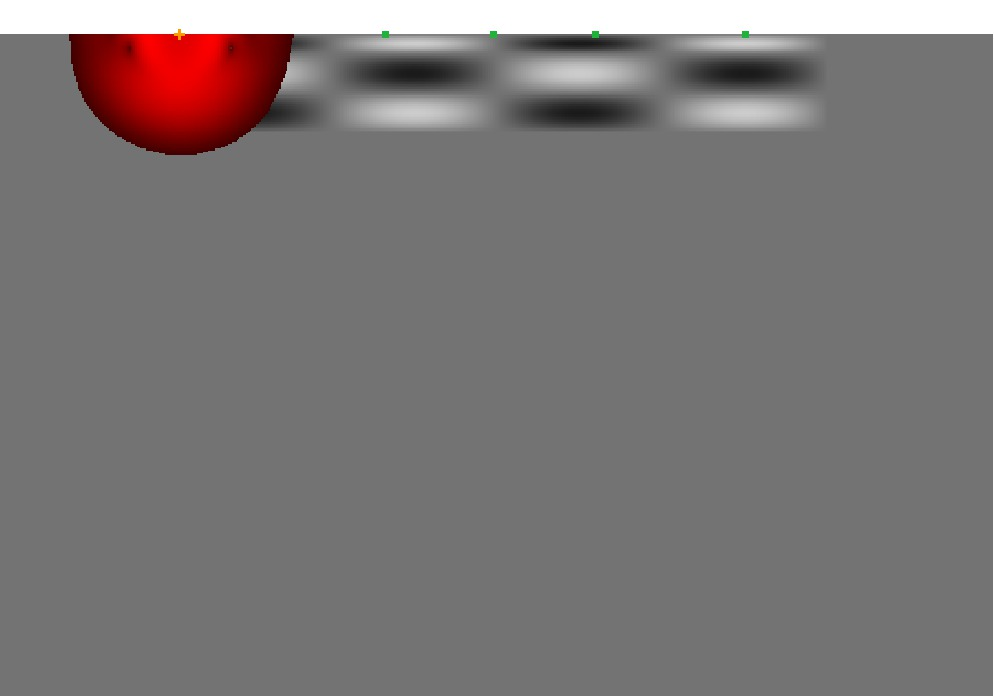

In [64]:
Image("OUTPUT_FILES/forward_image000001000.jpg")

Text(0, 0.5, 'Displacement [m]')

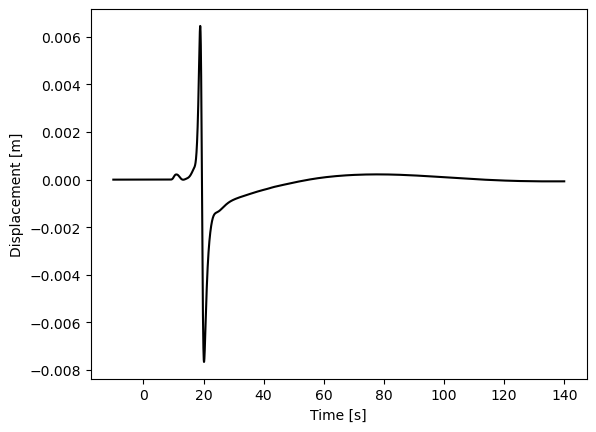

In [56]:
data = np.loadtxt("OUTPUT_FILES/IP.S0MBL.BXZ.semd", dtype=float)

plt.plot(data[:,0], data[:,1], c="k")
plt.xlabel("Time [s]")
plt.ylabel("Displacement [m]")